# IFT 599/799 – Science des données

## TP2 : Règles d’associations

Ce TP porte sur l’extraction des règles d’associations. Il consiste à développer une étude d’une base de données bancaire à l’aide des techniques d’analyse d’association. Le but de l’étude est d’identifier des profiles d’épargnants parmi les clients, identifier des non épargnants qui seraient intéressés d’acheter des produits d’épargne, et détecter des clients atypiques. A savoir, les épargnants sont les personnes possédant soit un plan "pep", soit un plan "mortgage". 
Afin de réaliser ce TP, nous avons choisi d'utiliser le language Python, possédant la librairie "apyori", une implémentation simple de l'algorithme d'Apriori, nous permettant d'effectuer la recherche d'itemsets fréquents. 

# Introduction : compréhension des données et pré-processing

In [1]:
## Dans un premier temps, il est nécessaire d'importer les différente librairies utilisées
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from apyori import apriori
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
## On lit ensuite les données qui sont sous un format csv, séparées par une virgule.
## On s'assure également qu'il n'existe aucun objet possédant une caractéristique vide
## grâce à la fonction dropna(). 

dataset = pd.read_csv('Sujet/bank-data.csv', sep=',', na_values='␣', encoding='latin-1')
dataset.dropna(how="all", inplace=True)

print("Forme du jeu de données bank-data.csv : ",dataset.shape)

Forme du jeu de données bank-data.csv :  (600, 12)


La forme de notre jeu de données nous montre qu'il possède 600 objets chacun composé de 12 attributs (détaillés ci-après). 

In [3]:
## Pour exemple, on peut visualiser 5 objets pris aléatoirement dans jeu de données: 
dataset.sample(frac=0.7).head()

,id,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
295,ID12396,34,MALE,TOWN,32548.9,YES,0,YES,YES,YES,YES,NO
345,ID12446,65,FEMALE,TOWN,42378.2,YES,1,NO,YES,YES,NO,YES
23,ID12124,27,FEMALE,TOWN,15538.8,NO,0,YES,YES,YES,YES,NO
501,ID12602,58,FEMALE,INNER_CITY,33007.3,NO,1,YES,NO,YES,NO,YES
343,ID12444,51,FEMALE,INNER_CITY,19416.8,YES,0,NO,YES,YES,NO,NO


Chaque ligne correspond ainsi à un objet de notre jeu de données, et chaque colonne un attribut. On peut observer que ces attributs correspondent à "id" (un identifiant unique attribué à une personne), "age" (l'âge de cette personne), "sex" (homme ou femme), "region" (le type de lieu où habite la personne), "income" (le revenu de cette personne), "married" (si la personne est marriée ou non), "children" (le nombre d'enfants de la personne), "car" (si la personne possède une voiture), "save_act" (si la personne a sauvegardé un compte), "current_act" (si la personne possède un compte en ce moment) , "mortgage" (si la personne possède un compte hypothèque) et "pep" (si la personne possède un compte dynamique). 
On remarque que l'ensemble des attributs correspondent à des valeurs catégoriques, mis à part "children", "income", "age" qui sont des ratios. 

Le but du TP est d'extraire des règles significatives afin de décrire les profils des épargnants, d'identifier des clients non-épargnants correspondant aux profiles extraits et enfin d'identifier des clients atypiques. 

### Preprocessing des données

Après avoir examiné nos données, nous nous sommes aperçus que les attributs ne possèdent pas les mêmes types de données (nous ne prenons pas en compte l'ID de chaque client qui ne nous servira pas dans la recherche d'itemset). Ainsi, il est dans un premier temps nécessaire d'effectuer un traitement sur l'âge, le revenu et le nombre d'enfants. Il est, dans un second temps, nécessaire de modifier le nom de nos variables catégoriques, qui pour la plupart sont "YES" et "NO", afin de permettre une meilleure lecture de nos résultats une fois l'algorithme d'Apriori appliqué. 

In [4]:
## Dans un premier temps, nous vérifions l'âge et le salaire maximal et minimal 
## de nos clients, ainsi que la médianne pour séparer en deux nos objets pour les deux attributs. 
print("L'âge maximal est de : " + str(dataset['age'].max()))
print("L'âge minimal est de : " + str(dataset['age'].min()))
print("La médiane de l'âge est de : " + str(dataset['age'].median()))
print("Le revenu maximal est de : " + str(dataset['income'].max()))
print("Le revenu minimal est de :" + str(dataset['income'].min()))
print("La médiane du revenu est de :" + str(dataset['income'].median()))

L'âge maximal est de : 67
L'âge minimal est de : 18
La médiane de l'âge est de : 42.0
Le revenu maximal est de : 63130.1
Le revenu minimal est de :5014.21
La médiane du revenu est de :24925.3


In [5]:
## Pour transformer nos ratios en variables catégoriques, nous allons
## séparer en deux nos objets grâce à la médiane, afin d'obtenir deux groupes
## possédant le même nombre d'individus
age1042 = dataset.loc[(dataset['age'] > 10) & (dataset['age'] <= 42),:]
age1042.loc[:,'age'] = "ageFrom10to42"
age4270 = dataset.loc[(dataset['age'] > 42) & (dataset['age'] <= 70),:]
age4270.loc[:,'age'] = "ageFrom42to70"
dataset = pd.concat([age1042, age4270])

## De même pour le revenu, nous séparons les objets en deux groupes selon la 
## médiane du revenu. 
income024k = dataset.loc[(dataset['income'] > 0) & (dataset['income'] <= 24925.3),:]
income024k.loc[:,'income'] = "income_From0to24k"
income24k70k = dataset.loc[(dataset['income'] > 24925.3) & (dataset['income'] <= 65000),:]
income24k70k.loc[:,'income'] = "income_From24kto65k"
dataset = pd.concat([income024k, income24k70k])
dataset.head()

## Concernant les enfants, il nous a paru judicieux de séparer les clients selon
## le fait qu'ils possèdent ou non des enfants, sans pour autant considérer le nombre
## exact d'enfants, afin d'éviter un trop grand nombre d'1-itemset. 
nochildren = dataset.loc[dataset['children'] == 0,:]
nochildren.loc[:,'children'] = "no_children"
yeschildren = dataset.loc[dataset['children'] > 0,:]
yeschildren.loc[:,'children'] = "yes_children"
dataset = pd.concat([nochildren, yeschildren])

## Finalement, pour chacune des autres variables, nous avons uniquement
## modifié le nom des différentes valeurs "YES" et "NO", afin de ne pas
## fausser les résultats de l'algorithme d'Apriori, ainsi que notre lecture
## des itemsets et règles d'associations. 
nomarried = dataset.loc[dataset['married'] == "NO",:]
nomarried.loc[:,'married'] = "no_married"
yesmarried = dataset.loc[dataset['married'] == "YES",:]
yesmarried.loc[:,'married'] = "yes_married"
dataset = pd.concat([nomarried, yesmarried])

nocar = dataset.loc[dataset['car'] == "NO",:]
nocar.loc[:,'car'] = "no_car"
yescar = dataset.loc[dataset['car'] == "YES",:]
yescar.loc[:,'car'] = "yes_car"
dataset = pd.concat([nocar, yescar])

nosave_act = dataset.loc[dataset['save_act'] == "NO",:]
nosave_act.loc[:,'save_act'] = "no_save_act"
yessave_act = dataset.loc[dataset['save_act'] == "YES",:]
yessave_act.loc[:,'save_act'] = "yes_save_act"
dataset = pd.concat([nosave_act, yessave_act])

nocurrent_act = dataset.loc[dataset['current_act'] == "NO",:]
nocurrent_act.loc[:,'current_act'] = "no_current_act"
yescurrent_act = dataset.loc[dataset['current_act'] == "YES",:]
yescurrent_act.loc[:,'current_act'] = "yes_current_act"
dataset = pd.concat([nocurrent_act, yescurrent_act])

nomortgage = dataset.loc[dataset['mortgage'] == "NO",:]
nomortgage.loc[:,'mortgage'] = "no_mortgage"
yesmortgage = dataset.loc[dataset['mortgage'] == "YES",:]
yesmortgage.loc[:,'mortgage'] = "yes_mortgage"
dataset = pd.concat([nomortgage, yesmortgage])

nopep = dataset.loc[dataset['pep'] == "NO",:]
nopep.loc[:,'pep'] = "no_pep"
yespep = dataset.loc[dataset['pep'] == "YES",:]
yespep.loc[:,'pep'] = "yes_pep"
dataset = pd.concat([nopep, yespep])

/Users/jouffroy/.local/share/virtualenvs/ProjetUdeS-ExtractionRegles-o6pjDpBg/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/jouffroy/.local/share/virtualenvs/ProjetUdeS-ExtractionRegles-o6pjDpBg/lib/python3.7/site-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [6]:
dataset.head()

,id,age,sex,region,income,married,children,car,save_act,current_act,mortgage,pep
259,ID12360,ageFrom10to42,MALE,TOWN,income_From0to24k,no_married,no_children,no_car,no_save_act,no_current_act,no_mortgage,no_pep
51,ID12152,ageFrom10to42,MALE,TOWN,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act,no_mortgage,no_pep
161,ID12262,ageFrom10to42,FEMALE,INNER_CITY,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act,no_mortgage,no_pep
164,ID12265,ageFrom10to42,FEMALE,INNER_CITY,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act,no_mortgage,no_pep
285,ID12386,ageFrom10to42,MALE,TOWN,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act,no_mortgage,no_pep


### Séparation des clients épargnants de ceux n'épargnant pas

Daprès la base de données, un épargnant est une personne ayant soit un « mortgage » soit un plan « pep ». Ainsi, un non-épargnant, est une possédant ni l'un ni l'autre des deux comptes. Ainsi, afin d'éxecuter l'algorithme d'Apriori, il est nécessaire de séparer en deux ces objets. 

In [7]:
## Dans un premier temps, on créé un nouveau DataFrame avec les personnes possédant soit un
## mortgage, soit un pep, soit les deux. Une fois ce tableau créé, nous pouvons supprimer ces deux
## attributs qui ne permettent que de séparer les deux types d'objets.
epargnant_pep = dataset[((dataset['pep'] == "yes_pep") & (dataset['mortgage'] == "no_mortgage")) ]
epargnant_mortgage = dataset[((dataset['pep'] == "no_pep") & (dataset['mortgage'] == "yes_mortgage"))]
epargnant_both =dataset[((dataset['pep'] == "yes_pep") & (dataset['mortgage'] == "yes_mortgage"))]
epargnant = pd.concat([epargnant_pep, epargnant_mortgage, epargnant_both])
epragnant_without = epargnant.drop(['mortgage', 'pep'], axis=1)
epargnant = pd.DataFrame(epragnant_without)

## Une fois ce tableau créé, nous créeons également un tableau pour les non-épargnants. 
non_epargnant = dataset[((dataset['pep'] == "no_pep") & (dataset['mortgage'] == "no_mortgage")) ]
non_epargnant_without = non_epargnant.drop(['mortgage', 'pep'], axis=1)
nonepargnant = pd.DataFrame(non_epargnant_without)

# Règles significatives pour les profils des épargnants

Afin de déduire les règles significatives nous permettant de déduire les profils des épargnants, nous avons appliqué l'algorithme d'Apriori, un algorithme permettant d'identifier les items fréquents et les règles d'associations qui y sont associées. Afin d'éffectuer cela, nous avons dans un premier temps regardé les supports pour chacun 1-itemset de la base de données possédant les personnes épargnant, puis nous avons effectué plusieurs tests avec différentes valeurs de minsup et différentes valeurs de minconf, afin de voir les règles d'associations les plus pertinentes qui en sortaient. Nous nous sommes arrêtés à 10 règles d'associations et avons affiché ces dernières. 


( Afin d'effectuer notre Apriori, nous nous sommes basés sur le code de l'article :
" Association Rule Mining via Apriori Algorithm in Python ", datant du 09 août 2018, rédigé par Usman Malik, trouvé à l'adresse suivante: https://stackabuse.com/association-rule-mining-via-apriori-algorithm-in-python/. )

### Différents essais afin d'établir des valeurs significatives pour minsup et minconf

In [8]:
items = []
for i in range(0, len(epargnant)):
    items.append([str(epargnant.values[i,j]) for j in range(0, len(epargnant.columns))])
    
association_rules = apriori(items, min_support=0.000001,  min_lift=0.05, min_confidence=0.02, max_length=1)
association_results = list(association_rules)
names = []
dfItemSupport = []
for item in association_results:
    names.append(str(list(item[2][0][1]))[2:-2])
    dfItemSupport.append(item[1])
    
dfItemSupport = pd.DataFrame(dfItemSupport).T
dfItemSupport.columns = names
dfItemSupport

,FEMALE,INNER_CITY,MALE,RURAL,SUBURBAN,TOWN,ageFrom10to42,ageFrom42to70,income_From0to24k,income_From24kto65k,no_car,no_children,no_current_act,no_married,no_save_act,yes_car,yes_children,yes_current_act,yes_married,yes_save_act
0,0.473146,0.442455,0.526854,0.161125,0.104859,0.29156,0.462916,0.537084,0.457801,0.542199,0.501279,0.398977,0.240409,0.424552,0.304348,0.498721,0.601023,0.759591,0.575448,0.695652


D'après les supports des 1-itemsets ci-dessus, on peut remarquer que les personnes épargnants sont pour la plupart les personnes vivant à l'intérieur d'une ville, dont l'âge est supérieur à 42 ans, étant marriés, possédant des enfants, possédant actuellement un compte et ayant sauvegardé un. 

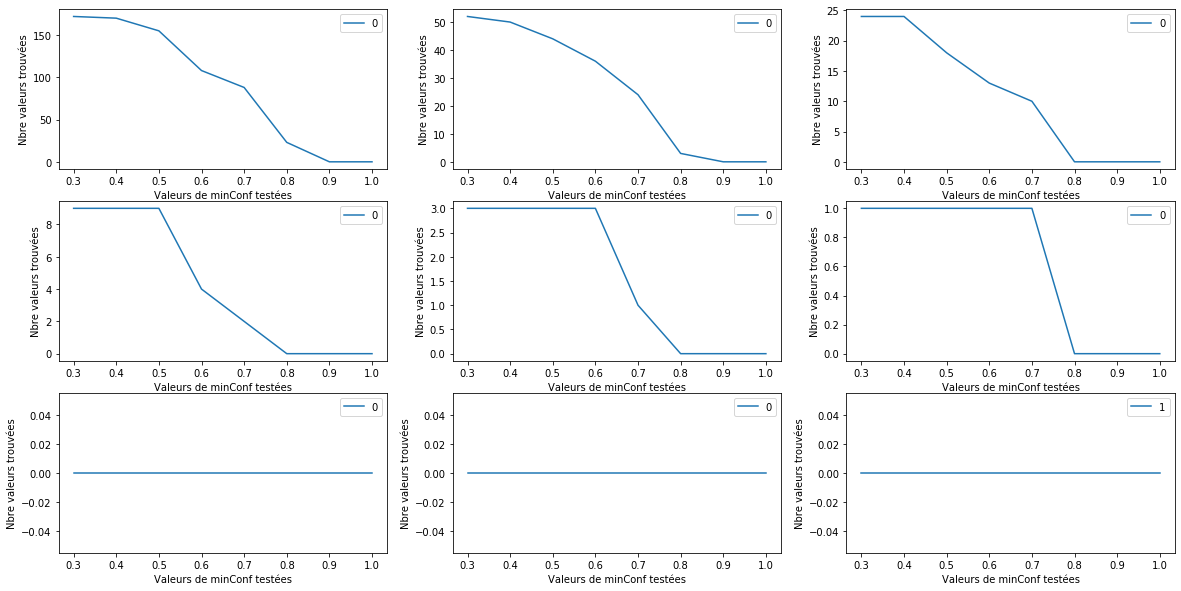

In [9]:
minSupValues = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
minconfValues = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
res=[]
for elt_supp in minSupValues:
    tmp = []
    for elt_conf in minconfValues:
        association_rules = apriori(items, min_support=elt_supp, min_confidence=elt_conf)
        tmp.append(len(list(association_rules)))
    res.append(tmp)

plt.figure(figsize=(20, 10))
for i in range(1,1+len(minSupValues)):
    plt.subplot(3, 3, i)
    plt.plot(minconfValues, res[i-1])
    plt.xlabel("Valeurs de minConf testées")
    plt.ylabel("Nbre règles trouvées")
    plt.legend(str(minSupValues[i-1]))
plt.show()

Ce graphique nous permet de déterminer les valeurs du support minimal et de la confiance minimale nous permettant de mettre à l'évidence une dizaine de règles pertinentes afin de caractériser les épargnants. Ainsi on remarque que pour un minsup à 30%, il existe environ une vingtaine de règles dont la confiance est supérieure ou égale à 70%. Ces règles sont ainsi pertinentes et c'est pourquoi nous nous attarderons sur ces valeurs pour appliquer l'algorithme.  

### Application de l'algorithme d'Apriori et mise en évidence des règles avec les valeurs déterminées

In [34]:
association_rules = apriori(items, min_support=0.3, min_conf=0.7)
association_results = list(association_rules)
for item in association_results:
    print("Rule: " + str(list(item[2][0][0])) + " -> " + str(list(item[2][0][1])))
    print("Support: " + str(item[1]))
    print("Confidence: " + str(item[2][0][2]))
    print("Lift: " + str(item[2][0][3]))
    print("=====================================")

Rule: [] -> ['FEMALE']
Support: 0.4731457800511509
Confidence: 0.4731457800511509
Lift: 1.0
Rule: [] -> ['INNER_CITY']
Support: 0.4424552429667519
Confidence: 0.4424552429667519
Lift: 1.0
Rule: [] -> ['MALE']
Support: 0.5268542199488491
Confidence: 0.5268542199488491
Lift: 1.0
Rule: [] -> ['ageFrom10to42']
Support: 0.4629156010230179
Confidence: 0.4629156010230179
Lift: 1.0
Rule: [] -> ['ageFrom42to70']
Support: 0.5370843989769821
Confidence: 0.5370843989769821
Lift: 1.0
Rule: [] -> ['income_From0to24k']
Support: 0.4578005115089514
Confidence: 0.4578005115089514
Lift: 1.0
Rule: [] -> ['income_From24kto65k']
Support: 0.5421994884910486
Confidence: 0.5421994884910486
Lift: 1.0
Rule: [] -> ['no_car']
Support: 0.5012787723785166
Confidence: 0.5012787723785166
Lift: 1.0
Rule: [] -> ['no_children']
Support: 0.3989769820971867
Confidence: 0.3989769820971867
Lift: 1.0
Rule: [] -> ['no_married']
Support: 0.42455242966751916
Confidence: 0.42455242966751916
Lift: 1.0
Rule: [] -> ['no_save_act']
S


Si on ne conserve que les 3-itemsets, alors on remarque que les épargnants possédant des enfants, et possédant un compte actuellement sont plus susceptibles de sauvegarder un compte, tout comme ceux possédant un compte et un revenu élevé ( de 24 000 à 65 000), ceux qui sont plus âgés (42 à 70 ans) et possédant un revenu élevé. 

## Identification des personnes non-épargnant ayant des profils d'épargnants

Afin d'identifier les personnes non-épargnants susceptibles d'ouvrir un compte épargne, nous allons regarder les personnes possédant l'ensemble des items présents dans les règles d'associations les plus fréquentes permettant de caractériser les profils des épargnants. Ainsi, ces 3-itemsets sont : {yes_current_act, yes_children, yes_save_act}, {yes_current_act, income_From24kto65k, yes_save_act}, {yes_current_act, ageFrom42to70, yes_save_act}, {ageFrom42to70, income_From24kto65k, yes_current_act}, mais également les personnes vivant à l'intérieur de la ville. 

In [15]:
nonepargnant.head()

,id,age,sex,region,income,married,children,car,save_act,current_act
259,ID12360,ageFrom10to42,MALE,TOWN,income_From0to24k,no_married,no_children,no_car,no_save_act,no_current_act
51,ID12152,ageFrom10to42,MALE,TOWN,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act
161,ID12262,ageFrom10to42,FEMALE,INNER_CITY,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act
164,ID12265,ageFrom10to42,FEMALE,INNER_CITY,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act
285,ID12386,ageFrom10to42,MALE,TOWN,income_From0to24k,yes_married,no_children,no_car,no_save_act,no_current_act


In [35]:
future_epargnant_current_act = nonepargnant.loc[(nonepargnant['current_act'] == "yes_current_act")  
                                                & (nonepargnant['save_act'] == "yes_save_act")
                                                & (nonepargnant['age'] == "ageFrom42to70")
                                                & (nonepargnant['children'] == "yes_children")
                                                & (nonepargnant['income'] == "income_From24kto65k")
                                               ]
future_epargnant_current_act

,id,age,sex,region,income,married,children,car,save_act,current_act
256,ID12357,ageFrom42to70,FEMALE,SUBURBAN,income_From24kto65k,no_married,yes_children,no_car,yes_save_act,yes_current_act
62,ID12163,ageFrom42to70,MALE,INNER_CITY,income_From24kto65k,yes_married,yes_children,no_car,yes_save_act,yes_current_act
140,ID12241,ageFrom42to70,MALE,INNER_CITY,income_From24kto65k,yes_married,yes_children,no_car,yes_save_act,yes_current_act
494,ID12595,ageFrom42to70,FEMALE,RURAL,income_From24kto65k,yes_married,yes_children,no_car,yes_save_act,yes_current_act
308,ID12409,ageFrom42to70,MALE,TOWN,income_From24kto65k,no_married,yes_children,yes_car,yes_save_act,yes_current_act
469,ID12570,ageFrom42to70,MALE,TOWN,income_From24kto65k,no_married,yes_children,yes_car,yes_save_act,yes_current_act
583,ID12684,ageFrom42to70,FEMALE,RURAL,income_From24kto65k,no_married,yes_children,yes_car,yes_save_act,yes_current_act
93,ID12194,ageFrom42to70,MALE,INNER_CITY,income_From24kto65k,yes_married,yes_children,yes_car,yes_save_act,yes_current_act
105,ID12206,ageFrom42to70,MALE,TOWN,income_From24kto65k,yes_married,yes_children,yes_car,yes_save_act,yes_current_act
381,ID12482,ageFrom42to70,FEMALE,INNER_CITY,income_From24kto65k,yes_married,yes_children,yes_car,yes_save_act,yes_current_act


Après avoir filtré les personnes sans épargnes à travers les caractéristiques que nous avons déterminées lors de l'application de l'algorithme d'Apriori sur les personnes épargnant, c'est à dire en conservant les 1-itemset les plus pertinents, nous pouvons constater que 6 personnes non épargnants sont susceptibles de devenir épargnants, soit les personnes possédant cles id suivants : "ID12163", "ID12241", "ID12194", "ID12482", "ID12653" et "ID12655". 

Ces résultats sont toutefois à prendre avec du recul. Effectivement, le pré-traitement que nous avons effectué sur nos données influent grandement sur ces résultats, et il serait ainsi possible d'obtenir d'avantages ou moins d'informations sur ces personnes en effectuant différemment la transformation d'attributs de ratios en données catégoriques. 

## Recherche de clients atypiques